# Before Lecture

- best assignment 3 presentation.
- 4th compulsary project meeting on Week 8 and 9.
  - Later meetings will be optional after week 9.
- Project submission date
- Data requests is optional and no promise from ADA end.



# House Keeping

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import patsy
from econml.dml import LinearDML
from econml.sklearn_extensions.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper

# Reading

1. Textbook Page 163-199
1. [Chernozhukov2024](https://arxiv.org/abs/1608.00060), since 2016

Experiments might not exist or be in a good shape. A brutal intuition is simply adding more $x$ variables. What $x$ is useful depends on the context and belief. In practice, many empirical research just tosses in anything they can get. But we can toss them better...

# Orange Juice

- Conditional Ingnorability (CI, not Confidence Interval). We can have ALL variables that influence both *treatment* and *response*. Or, simply (6.1)
$$\{y_i(d) \quad \forall d \} \perp d_i \mid x_i.$$
For a simple linear regression model,
$$y_i = x_i'\beta + \gamma d_i + ɛ_i, $$
CI implies $d_i$ is independent of $ɛ_i$. This is a typical exogeneity assumption.

In [ ]:
oj = pd.read_csv("https://www.dropbox.com/s/8oll01xv92mkij8/oj.csv?dl=1")
oj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28947 entries, 0 to 28946
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   28947 non-null  float64
 1   price   28947 non-null  float64
 2   brand   28947 non-null  object 
 3   feat    28947 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 904.7+ KB


A log-log regression to get at elasticities:
- Obviously problematic. Why? Endogeneity, missing variable problem.

In [ ]:
model = smf.ols("I(np.log(sales))~I(np.log(price))", data=oj)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       I(np.log(sales))   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     7608.
Date:                Thu, 04 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:27:25   Log-Likelihood:                -38251.
No. Observations:               28947   AIC:                         7.651e+04
Df Residuals:                   28945   BIC:                         7.652e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           10.4234      0.015  

Controlling for brands in OLS:
- Brand may affect price and sales at the same time. Do you have a story?

In [ ]:
model = smf.ols("I(np.log(sales))~I(np.log(price))+brand", data=oj)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       I(np.log(sales))   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     6275.
Date:                Thu, 04 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:27:28   Log-Likelihood:                -34377.
No. Observations:               28947   AIC:                         6.876e+04
Df Residuals:                   28943   BIC:                         6.880e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               10.8288 

## 2-Stage Least Squares
Residualizing to show what partialing out things mean:

- purging out the control variables' effect.
- the left residual is exogenous **shock**
- The technique detail is called [Frisch–Waugh–Lovell theorem](https://en.wikipedia.org/wiki/Frisch%E2%80%93Waugh%E2%80%93Lovell_theorem).

In [ ]:
model_price = smf.ols("I(np.log(price))~brand", data=oj)
results_price = model_price.fit()

In [ ]:
results_price.resid

0        0.318657
1        0.318657
2        0.318657
3        0.318657
4        0.318657
           ...   
28942    0.166179
28943    0.135720
28944   -0.063234
28945   -0.128192
28946    0.032648
Length: 28947, dtype: float64

In [ ]:
model = smf.ols("I(np.log(sales))~I(results_price.resid)", data=oj)
results = model.fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       I(np.log(sales))   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                 1.868e+04
Date:                Tue, 02 Sep 2025   Prob (F-statistic):               0.00
Time:                        12:19:04   Log-Likelihood:                -34421.
No. Observations:               28947   AIC:                         6.885e+04
Df Residuals:                   28945   BIC:                         6.886e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  9

Traditionally, and for methodological consistency, you would also residualize the left-hand side when you residualize the right-hand size. 

You can also Google or Gemini the **Frisch-Waugh-Lovell Theorem**. Frisch also shared the first Nobel Prize in economics.

In [ ]:
model_sale = smf.ols("I(np.log(sales))~brand", data=oj)
results_sale = model_sale.fit()

In [ ]:
results_sale.resid

0       -0.092787
1       -0.388252
2       -0.858255
3       -0.124286
4       -0.018126
           ...   
28942   -1.187306
28943   -0.672142
28944    0.331160
28945    1.752545
28946   -0.315467
Length: 28947, dtype: float64

In [ ]:
model = smf.ols("results_sale.resid ~-1+ results_price.resid", data=oj)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:     results_sale.resid   R-squared (uncentered):                   0.393
Model:                            OLS   Adj. R-squared (uncentered):              0.393
Method:                 Least Squares   F-statistic:                          1.874e+04
Date:                Thu, 04 Sep 2025   Prob (F-statistic):                        0.00
Time:                        16:27:54   Log-Likelihood:                         -34377.
No. Observations:               28947   AIC:                                  6.876e+04
Df Residuals:                   28946   BIC:                                  6.877e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

# Linear Treatment Effects (LTE) model
$$y = d\gamma + x'\beta + ɛ, \quad E[ɛ\mid d, x] = 0$$
and
$$d=x'\tau + ν, \quad E[\nu\mid x]=0$$

- If you want to control a confounder, you may add it as input.
- If the dimension becomes large, ML comes to play.

## Abortion and Crime

Let's turn to a famous line of research, earning Levitt a Clark Medal (also Google Melissa Dell) and the [Freakonomics](https://freakonomics.com/) franchise. You may listen to its [podcast](https://freakonomics.com/podcast/abortion-and-crime-revisited/) on your way.

In [ ]:
# URL of the data file
url = "https://www.dropbox.com/s/txwf5afmsqioonr/abortion.dat?dl=1"

# Read the data from the URL
data = pd.read_csv(url, sep="\t", skiprows=0)

# Assign column names
data.columns = ["state", "year", "pop", "y_viol", "y_prop", "y_murd", "a_murd", "a_viol", "a_prop", "prison", "police", "ur", "inc", "pov", "afdc", "gun", "beer"]

print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   state   1734 non-null   int64  
 1   year    1734 non-null   int64  
 2   pop     1530 non-null   float64
 3   y_viol  1320 non-null   float64
 4   y_prop  1320 non-null   float64
 5   y_murd  1320 non-null   float64
 6   a_murd  663 non-null    float64
 7   a_viol  663 non-null    float64
 8   a_prop  663 non-null    float64
 9   prison  1275 non-null   float64
 10  police  1275 non-null   float64
 11  ur      1326 non-null   float64
 12  inc     1326 non-null   float64
 13  pov     918 non-null    float64
 14  afdc    714 non-null    float64
 15  gun     1683 non-null   float64
 16  beer    714 non-null    float64
dtypes: float64(15), int64(2)
memory usage: 230.4 KB
None
   state  year     pop  y_viol  y_prop  y_murd  a_murd  a_viol  a_prop  \
0      1    66     NaN     NaN     NaN     NaN     NaN    

## Questions and Data

- Research conclusion: Easy access to abortion causes crime to decrease. It implies that high-quality raising of children is important for national security and extends to prosperity.
- If you want to convert a question to an econometric problem, you need to translate.
  - What is a crime? How to represent it by data?
  - What is “access” to abortion in data?
  - Why does the textbook uses murder rate? See Page 167.

Some variable descriptions:

* prison: log of lagged prisoners per capita
* police: the log of lagged police per capita
* ur: the unemployment rate
* inc: per-capita income
* pov: the poverty rate
* AFDC: generosity at year t-15 (charity)
* gun: dummy for concealed weapons law
* beer: beer consumption per capita

In [ ]:
# Exclude specific states (2, 9, 12)
# AK, DC, HA are strange places (according to the authors).
excluded_states = [2, 9, 12]
data = data[~data['state'].isin(excluded_states)]

In [ ]:
# Filter years between 1985 and 1997
# incomplete data outside these years
data = data[(data['year'] > 84) & (data['year'] < 98)]

In [ ]:
# Log-transform population
data['pop'] = np.log(data['pop'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 624 entries, 19 to 1731
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   state   624 non-null    int64  
 1   year    624 non-null    int64  
 2   pop     624 non-null    float64
 3   y_viol  624 non-null    float64
 4   y_prop  624 non-null    float64
 5   y_murd  624 non-null    float64
 6   a_murd  624 non-null    float64
 7   a_viol  624 non-null    float64
 8   a_prop  624 non-null    float64
 9   prison  624 non-null    float64
 10  police  624 non-null    float64
 11  ur      624 non-null    float64
 12  inc     624 non-null    float64
 13  pov     624 non-null    float64
 14  afdc    624 non-null    float64
 15  gun     624 non-null    float64
 16  beer    624 non-null    float64
dtypes: float64(15), int64(2)
memory usage: 87.8 KB


In [ ]:
# Calculate 't' and create 's' as a factor (categorical variable)
data['t'] = data['year'] - 85
data['s'] = pd.Categorical(data['state'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 624 entries, 19 to 1731
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   state   624 non-null    int64   
 1   year    624 non-null    int64   
 2   pop     624 non-null    float64 
 3   y_viol  624 non-null    float64 
 4   y_prop  624 non-null    float64 
 5   y_murd  624 non-null    float64 
 6   a_murd  624 non-null    float64 
 7   a_viol  624 non-null    float64 
 8   a_prop  624 non-null    float64 
 9   prison  624 non-null    float64 
 10  police  624 non-null    float64 
 11  ur      624 non-null    float64 
 12  inc     624 non-null    float64 
 13  pov     624 non-null    float64 
 14  afdc    624 non-null    float64 
 15  gun     624 non-null    float64 
 16  beer    624 non-null    float64 
 17  t       624 non-null    int64   
 18  s       624 non-null    category
dtypes: category(1), float64(15), int64(3)
memory usage: 94.7 KB


In [ ]:
controls = data.iloc[:, [2] + list(range(9, 17))]

# Get column names of 'controls'
control_colnames = controls.columns.tolist()

# Display the column names of 'controls'
print(control_colnames)

['pop', 'prison', 'police', 'ur', 'inc', 'pov', 'afdc', 'gun', 'beer']


In [ ]:
controls.isna().any()

pop       False
prison    False
police    False
ur        False
inc       False
pov       False
afdc      False
gun       False
beer      False
dtype: bool

In [ ]:
controls.head()

,pop,prison,police,ur,inc,pov,afdc,gun,beer
19,8.287277,0.952666,0.762663,0.08908,9.703193,20.6,3077.629,1.0,18.7
20,8.292048,0.995291,0.790903,0.09833,9.745950,23.8,2805.778,1.0,19.3
21,8.297793,1.058402,0.818914,0.07775,9.762092,21.3,3455.742,1.0,19.4
22,8.300032,1.143818,0.880334,0.07208,9.781770,19.3,3210.000,1.0,19.4
23,8.301522,1.121946,0.941032,0.07025,9.802527,18.9,3789.493,1.0,19.4


Key: `y` is de-trended log crime rate, criminal-age-weighted prior abortion rate `a` is as described below. Note we also have violent and property crime versions for both.

In [ ]:
y = data['y_murd']
d = data['a_murd']
t = data['t']
s = data['s']

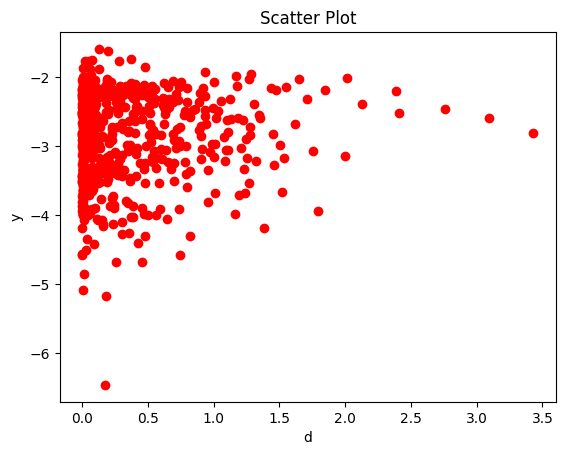

In [ ]:
plt.scatter(d, y, marker='o', c='red')  # 'marker' sets the marker type, 'c' sets the color
plt.xlabel('d')
plt.ylabel('y')
plt.title('Scatter Plot')
plt.show()

The abortion `a_` variables are weighted average of abortion rates where weights are determined by the fraction of the type of crime committed by various age groups.

- For example, if 60% of violent crime were committed by 18-year-olds and 40% were committed by 19 year olds in state `i`, the abortion rate for violent crime at time `t` in state `i` would be constructed as `.6` times the abortion rate in state `i` at time `t − 18` plus `.4` times the abortion rate in state `i` at time `t − 19`. See Donohue and Levitt (2001) for further detail.

We'll just look at murder.
Note that for convenience here we've made `y,d,t` global: they are not in `controls`.

Let's win a [Clark Medal](https://en.wikipedia.org/wiki/John_Bates_Clark_Medal).

- Fact: the medal is quite concentrated at a few shiny star universities.

In [ ]:
s.info()

<class 'pandas.core.series.Series'>
Index: 624 entries, 19 to 1731
Series name: s
Non-Null Count  Dtype   
--------------  -----   
624 non-null    category
dtypes: category(1)
memory usage: 6.9 KB


In [ ]:
control_names = controls.columns
formula = "y~d+s+t+" + "+".join(control_names)
model = smf.ols(formula=formula, data=controls)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     99.87
Date:                Thu, 04 Sep 2025   Prob (F-statistic):          4.47e-259
Time:                        16:28:59   Log-Likelihood:                 133.78
No. Observations:                 624   AIC:                            -149.6
Df Residuals:                     565   BIC:                             112.2
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8290      4.272      1.131      0.2

That abortion is only one factor influencing crime in the late 1980s points out the caution required in drawing any conclusions regarding an abortion-crime link based on time series evidence alone.

As a cautionary example, let's repeat the analysis, but for cellphones rather than abortion:

In [ ]:
cell = pd.read_csv("https://www.dropbox.com/s/pgvxxtviyqqudau/us_cellphone.csv?dl=1")
cell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   year         13 non-null     int64
 1   subscribers  13 non-null     int64
 2   pop          13 non-null     int64
dtypes: int64(3)
memory usage: 444.0 bytes


In [ ]:
cellrate = 5 * cell.iloc[:, 1] / (1000 * cell.iloc[:, 2])

A smart observation: there are many things that increased with similar (but non-linear) shapes over time (cellphone usage, yoga revenues, home prices, ...). Is this loading onto abortion? What if we're just fitting a quadratic trend?

- Go to [Spurious Correlation](http://www.tylervigen.com/spurious-correlations), find a figure you like and try to explain the causality as HARD as possible.
- Always be careful when you are dealing with time series data. In general, all data with a time stamp.

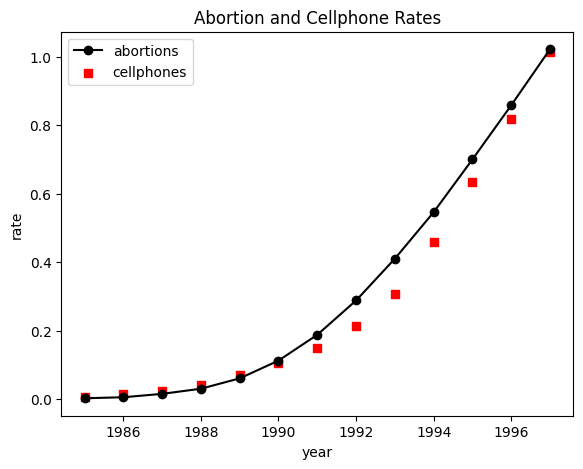

In [ ]:
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Plot mean of 'd' against 't'
years = np.arange(1985, 1998)
mean_d_by_t = [np.mean(d[t == i]) for i in range(13)]

plt.plot(years, mean_d_by_t, marker='o', linestyle='-', color='black', label='abortions')

# Plot 'cellrate'
plt.scatter(years, cellrate, marker='s', color='red', label='cellphones')

# Set plot labels and title
plt.xlabel('year')
plt.ylabel('rate')
plt.title('Abortion and Cellphone Rates')
plt.legend()

# Display the plot
plt.show()

In [ ]:
phone = cellrate[t]
phone.index = t.index

In [ ]:
phone

19      0.007150
20      0.014197
21      0.025401
22      0.042320
23      0.071083
          ...   
1727    0.307970
1728    0.458610
1729    0.633899
1730    0.817446
1731    1.014357
Length: 624, dtype: float64

In [ ]:
control_names = controls.columns
formula = "y~phone+s+t+" + "+".join(control_names)
model = smf.ols(formula=formula, data=controls)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     100.4
Date:                Thu, 04 Sep 2025   Prob (F-statistic):          1.23e-259
Time:                        16:29:19   Log-Likelihood:                 135.23
No. Observations:                 624   AIC:                            -152.5
Df Residuals:                     565   BIC:                             109.3
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6428      4.349      0.608      0.5

What is happening here is that our key variable has been increasing quadratically, and we have no other controls that do so.  To be correct, you need to allow quadratic trends that could be caused by other confounding variables (e.g. technology).

In addition, we may also allow interaction between the controls and interact the nationwide phone variable with state dummies to allow for state-specific tech adoption.

In [ ]:
t = t.astype(object) #without this steps, t is a numeric variable
control_names = controls.columns
formula = "y~d + t + phone*s +(" + "+".join(control_names) + ")**2"
model = smf.ols(formula=formula, data=controls)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     47.91
Date:                Thu, 04 Sep 2025   Prob (F-statistic):          5.78e-216
Time:                        16:29:23   Log-Likelihood:                 252.50
No. Observations:                 624   AIC:                            -199.0
Df Residuals:                     471   BIC:                             479.7
Df Model:                         152                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        44.8107     41.567      1.078

In [ ]:
data.to_csv('abortion_crime_data.csv', index=False)
controls.to_csv('abortion_crime_controls.csv', index=False)
phone.to_csv('abortion_crime_phone.csv', index=False)

# [EconML](https://econml.azurewebsites.net/index.html)

- A nice intro [presentation](https://www.dropbox.com/scl/fi/6cfgoru344bv2soqecgjc/Causal-Inference-User-Guide-v4-022520.pdf?rlkey=9lk6dg68x5iw6slzpyet7vb99&dl=0) from EconML.
- An online [notebook](https://drive.google.com/file/d/1tJRI5Pa9yy3SAwAtSC_jdLwHNqfhHYpO/view?usp=sharing) from EconML.

In [ ]:
data= pd.read_csv("https://www.dropbox.com/scl/fi/br06oykhs45ercnenbsnp/abortion_crime_data.csv?rlkey=6l2vlblqnwa02u2i38x917rh0&dl=1")
controls = pd.read_csv("https://www.dropbox.com/scl/fi/9iq3hpmob2dddlcelzry8/abortion_crime_controls.csv?rlkey=tjtbws9c7ie7a7svn7gec802e&dl=1")
phone = pd.read_csv('https://www.dropbox.com/scl/fi/n0kdsjju6pyi0nw778f3y/abortion_crime_phone.csv?rlkey=bsycnmvnqbccoy0r2rt35cn1v&dl=1')

y = data['y_murd']
d = data['a_murd']
t = data['t'].astype(object)
s = data['s'].astype(object)
phone = phone.iloc[:, 0]

## User's Manual

- $Y$ is the outcome.
- $T$ is the treatment.
- $X$ is the heterogeneity for the treatment effects, NOT necessarily the regressors.
- $W$ is confounders (controls)

In [ ]:
control_names = controls.columns
formula = "y ~ t + phone*s +(" + "+".join(control_names) + ")**2"
Y, W = patsy.dmatrices(formula, data=controls) # type: ignore
formula = "d ~ t + phone*s +(" + "+".join(control_names) + ")**2"
T, W = patsy.dmatrices(formula, data=controls) # type: ignore

In [ ]:
model_t = LassoCV(cv=5, alphas=np.logspace(-3, 2, 50), max_iter=10000)
model_y = LassoCV(cv=5, alphas=np.logspace(-3, 2, 50), max_iter=10000)

Y = Y.ravel()

In [ ]:
model_t.fit(W, T.ravel())

In [ ]:
model_t_cv = Lasso(alpha=model_t.alpha_, max_iter=10000)

In [ ]:
model_y.fit(W, Y)

In [ ]:
model_y_cv = Lasso(alpha=model_y.alpha_, max_iter=10000)

In [ ]:
estimator = LinearDML(
    model_y = model_y_cv, # type: ignore
    model_t = model_t_cv, # type: ignore
    cv=4,
)

In [ ]:
estimator.fit(Y=Y, T=T, W=W)

/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.199e+01, tolerance: 1.012e-02
  model = cd_fast.enet_coordinate_descent(
/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e+01, tolerance: 1.998e-02
  model = cd_fast.enet_coordinate_descent(
/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

In [ ]:
estimator.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-0.089,0.047,-1.872,0.061,-0.182,0.004


In [ ]:
estimator.const_marginal_ate()

array([-0.08872652])

In [ ]:
estimator.const_marginal_ate_inference()

In [ ]:
estimator.const_marginal_ate_interval()

(array([-0.1816055]), array([0.00415246]))

## Linear Models are NOT ideal

In [ ]:
model_y = LinearRegression()
model_t = LinearRegression()

In [ ]:
estimator = LinearDML(
    model_y = model_y, # type: ignore
    model_t = model_t, # type: ignore
    cv = 4
)

In [ ]:
estimator.fit(Y=Y, T=T, W=W)

In [ ]:
estimator.const_marginal_ate()

array([0.37007073])

In [ ]:
estimator.const_marginal_ate_interval()

(array([0.03219107]), array([0.70795038]))

## Heterogeneous Treatment Effect

What might affect treatment effect?

In [ ]:
control_names = controls.columns
formula = "y ~ phone*s +(" + "+".join(control_names) + ")**2"
Y, W = patsy.dmatrices(formula, data=controls) # type: ignore
formula = "d ~ t"
T, X = patsy.dmatrices(formula, data=controls) # type: ignore

In [ ]:
Y = Y.ravel()

In [ ]:
model_t = LassoCV(cv=5, alphas=np.logspace(-3, 2, 50), max_iter=10000)
model_y = LassoCV(cv=5, alphas=np.logspace(-3, 2, 50), max_iter=10000)

Y = Y.ravel()

In [ ]:
model_t.fit(W, T.ravel())
model_t_cv = Lasso(alpha=model_t.alpha_, max_iter=10000)
model_y.fit(W, Y)
model_y_cv = Lasso(alpha=model_y.alpha_, max_iter=10000)

In [ ]:
estimator = LinearDML(
    model_y = model_y_cv, # type: ignore
    model_t = model_t_cv, # type: ignore
    cv=4)

In [ ]:
estimator.fit(Y=Y, T=T, X=X, W=W)

/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.152e+01, tolerance: 1.132e-02
  model = cd_fast.enet_coordinate_descent(
/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e+01, tolerance: 1.852e-02
  model = cd_fast.enet_coordinate_descent(
/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

In [ ]:
estimator.const_marginal_ate(X)

array([-0.16842393])

In [ ]:
X0 = np.asarray(X)
X0.shape

In [ ]:
Xu = np.unique(X0, axis=0)

In [ ]:
me = estimator.const_marginal_effect(Xu)

In [ ]:
me_inter = estimator.const_marginal_effect_interval(Xu)

/var/folders/f5/l9hpzl4n77d48t3cndd3jf9m0000gn/T/ipykernel_80164/3819123879.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


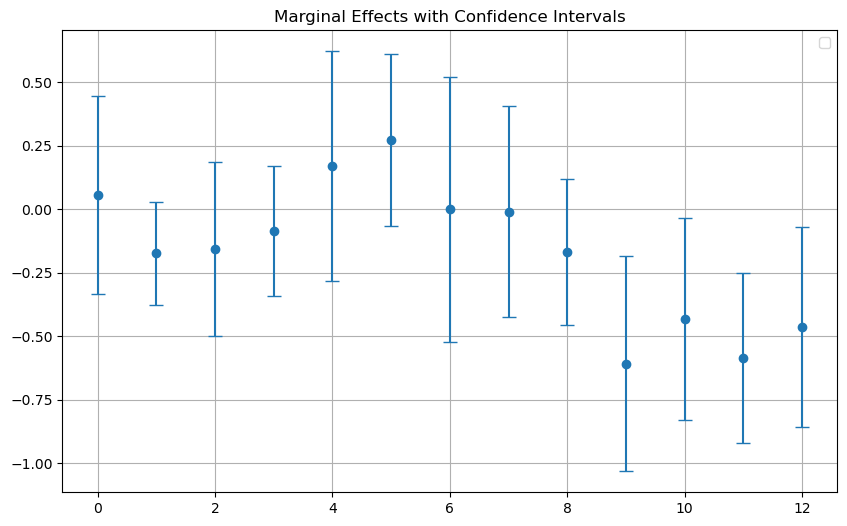

In [ ]:
y_values = me.ravel()
x_values = np.arange(len(y_values))
lower_bounds = me_inter[0].ravel()
upper_bounds = me_inter[1].ravel()

plt.figure(figsize=(10, 6))
plt.errorbar(x_values, y_values, yerr=[y_values - lower_bounds, upper_bounds - y_values],
             fmt='o', capsize=5)
plt.title('Marginal Effects with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
estimator.const_marginal_ate_inference(X)

# Double Machine Learning (DML)

- critical thinking, my friends.

[Chernozhukov2024](https://arxiv.org/abs/1608.00060), since 2016. Very difficult paper, but easy to understand the results with an example.

**Note**, this example is not unique. There are many examples includeing IV methods.

$$Y=D\theta_0 + g_0(X)+U, \quad E(U\mid X, D)=0$$
$$D = m_0(X)+V, \quad E(V\mid X)=0$$


- $\theta_0$ is not easy to be unbiased if $g_0$ is messy such as large dimensionality.
    - Any regularisation such as LASSO may bias the causal effect.
    - But regularisation may be necessary if there are many covariates.

- We can use $V$ as as IV!
    1. $V$ is related to $D$.
    1. $V$ is unrelated to $U$.

- However, due to the nature of ML, the resisual $\hat{V}$ would not be independent of $U$ easily.

- But, what if we **split the data** as in the cross validation?

- We did it!! This is Double Machine Learning!
    1. Split the data.
    1. Use the training part to estimate $m_0$ and $g_0$.
    2. Get an *OOS* prediction of $\hat{V}$ with $D$ model.
    3. Use $\hat{V}$ with $Y$ model to obtain $\hat{\theta}$ by using the test sample.
    4. You may average the $\hat{\theta}$ from different folds, or aggregate the folds first to get an consolidated $\hat{\theta}$. Later is preferred. Fortunately, we do not need to do it by hands.




## linking DML paper to EconML

Use the model

$$Y=D\theta_0 + g_0(X)+U, \quad E(U\mid X, D)=0$$
$$D = m_0(X)+V, \quad E(V\mid X)=0$$

**CATE** is conditional Average Treatment Effect

$$Y-E(Y\mid X) = [D-E(D\mid X)]\theta_0 + U$$
$g_0(X)$ is canceled out.

That is why we need
 - residual from model Y for $Y-E(Y\mid X)$, and
 - residual from model T for $D-E(D\mid X)$

Why do we need CV? Because we want to estimate the population $Y-E(Y\mid X)$ well. 
Any *population* is OOS, so CV is preferred!! 
The IV story from the DML paper is consistent with EconML if we disentagle the formula.
They share the same idea of the 2SLS method and the FWL theorem.

# Synthetic controls

Find similar observables to represent the control group.

For a simple example, assume time series data $y_{it}$, where $y_{it}(1)$ if treated and $y_{it}(0)$ otherwise. We can only observe one of them. Suppose the treatment happens at time $T$ for $i=1$.

- Only one series ($i=1$) is treated.
  - You observe $y_{1t}=y_{1t}(0)$ for $t=1,2,...,T$.
  - and $y_{1, T+1}(1)$.

Suppose there are $J$ series including the treated one $i=1$. All other $J-1$ series are not treated.

- We only observe $y_{kt}(0)$ for $k=2,...,J$ and $t=1,...,T, T+1$.

The TE is
$$y_{1, T+1}(1)- y_{1, T+1}(0).$$
- Which one is unobservable?





## Matrix Completion

$$\begin{bmatrix}
y_{11}(0) & y_{12}(0) & \cdots & y_{1T}(0) & ? \\
y_{21}(0) & y_{22}(0) & \cdots & y_{2T}(0) & y_{2, T+1}(0) \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
y_{J1}(0) & y_{J2}(0) & \cdots & y_{JT}(0) & y_{J, T+1}(0) \\
\end{bmatrix}$$

- Use data from other series to predict series $1$.
---
**Algorithm 16**

1. Build a model for $E[y_{1t}(0)\mid y_{-1t}(0)]$ and estimate by using data $t=1,...,T.$
2. Use the model to predict unobserved $y_{1t}(0)$ for $t>T$. The treatment effect is
$$\hat{γ}_{1, T+s} = y_{1,T+s}(1) - \hat{y}_{1,T+s}(0).$$
---

Application: the economic cost of terrorism in the Basque region of Spain. The terrorists' attack started in 1968.

In [ ]:
basque = pd.read_csv('https://www.dropbox.com/scl/fi/lh0mnk3sezvnoen70ltit/basque.csv?rlkey=jhvyygd2mmmhtlavrte8kswxs&dl=1')
basque.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   regionno               774 non-null    int64  
 1   regionname             774 non-null    object 
 2   year                   774 non-null    int64  
 3   gdpcap                 774 non-null    float64
 4   sec.agriculture        90 non-null     float64
 5   sec.energy             90 non-null     float64
 6   sec.industry           90 non-null     float64
 7   sec.construction       90 non-null     float64
 8   sec.services.venta     90 non-null     float64
 9   sec.services.nonventa  90 non-null     float64
 10  school.illit           108 non-null    float64
 11  school.prim            108 non-null    float64
 12  school.med             108 non-null    float64
 13  school.high            108 non-null    float64
 14  school.post.high       108 non-null    float64
 15  popden

In [ ]:
y = pd.read_csv('https://www.dropbox.com/scl/fi/j6f0id4fp8hrf4no4nvt7/basque_1.csv?rlkey=4jm3jq6c8mwy1753o7ao4ya6x&dl=1')
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1955    17 non-null     float64
 1   1956    17 non-null     float64
 2   1957    17 non-null     float64
 3   1958    17 non-null     float64
 4   1959    17 non-null     float64
 5   1960    17 non-null     float64
 6   1961    17 non-null     float64
 7   1962    17 non-null     float64
 8   1963    17 non-null     float64
 9   1964    17 non-null     float64
 10  1965    17 non-null     float64
 11  1966    17 non-null     float64
 12  1967    17 non-null     float64
 13  1968    17 non-null     float64
 14  1969    17 non-null     float64
 15  1970    17 non-null     float64
 16  1971    17 non-null     float64
 17  1972    17 non-null     float64
 18  1973    17 non-null     float64
 19  1974    17 non-null     float64
 20  1975    17 non-null     float64
 21  1976    17 non-null     float64
 22  1977

In [ ]:
tyear = 1968
y0t = y.iloc[:, :(tyear - 1954)].T
y1t = y.iloc[:, (tyear - 1954):].T

In [ ]:
y0t

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1955,3.853185,1.688732,2.288775,2.502928,3.143959,1.914382,2.559412,1.729149,1.327764,3.546630,2.575978,1.243430,1.634676,4.594473,1.679520,2.555127,2.390460
1956,3.945658,1.758498,2.445159,2.615538,3.347758,2.071837,2.693873,1.838332,1.415096,3.690446,2.738503,1.332548,1.725578,4.786632,1.764282,2.698158,2.535204
1957,4.033562,1.827621,2.603399,2.725793,3.549629,2.226078,2.820337,1.947658,1.503570,3.826835,2.899886,1.422451,1.816481,4.963439,1.850328,2.839831,2.680020
1958,4.023422,1.852756,2.639032,2.751857,3.642673,2.220866,2.879035,1.971365,1.531420,3.875678,2.963510,1.440231,1.840903,4.906170,1.887389,2.881891,2.726435
1959,4.013782,1.878035,2.677092,2.777421,3.734862,2.213439,2.943730,1.995144,1.559340,3.921737,3.026207,1.458083,1.865396,4.846401,1.924093,2.930877,2.772851
1960,4.285918,2.010140,2.881462,2.967295,4.058841,2.357684,3.137032,2.138817,1.667524,4.241788,3.219294,1.535847,1.983290,5.161097,2.118609,3.163525,2.969866
1961,4.574336,2.129177,3.099543,3.143887,4.360254,2.445730,3.327621,2.239503,1.752428,4.575335,3.362468,1.596258,2.005784,5.632605,2.305484,3.335904,3.153171
1962,4.898957,2.280348,3.359183,3.373536,4.646173,2.648243,3.555341,2.454227,1.920451,4.838046,3.569980,1.705584,2.185661,5.840831,2.521422,3.623393,3.404384
1963,5.197015,2.431020,3.614182,3.597258,4.911525,2.844759,3.771423,2.672237,2.091902,5.081334,3.765210,1.817695,2.366395,6.024493,2.739074,3.894816,3.669238
1964,5.338903,2.508855,3.680091,3.672594,5.050700,2.951157,3.839403,2.777778,2.182591,5.158098,3.823693,1.882819,2.458797,6.099329,2.851257,3.985147,3.803985


In [ ]:
y1t

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1969,6.081405,3.179092,4.476221,4.549700,6.581691,3.912882,4.610826,3.520994,2.947444,5.915524,4.486290,2.381962,3.177378,6.435590,3.706155,4.765710,4.603542
1970,6.170094,3.354327,4.596258,4.631605,6.887032,4.224936,4.791417,3.670523,3.136890,6.066838,4.654741,2.518495,3.361968,6.543345,3.906384,4.979434,4.793416
1971,6.283633,3.522922,4.723722,4.699657,7.168666,4.493573,4.969652,3.821837,3.319623,6.227649,4.817124,2.654028,3.534776,6.674736,4.086475,5.199657,4.983362
1972,6.555555,3.756213,5.001285,5.022565,7.570694,4.781919,5.155384,4.081762,3.629177,6.539060,5.138889,2.846401,3.783205,7.086904,4.379463,5.466795,5.230077
1973,6.810769,3.987718,5.283491,5.345615,7.956298,5.054913,5.338760,4.345402,3.946087,6.837975,5.449372,3.045630,4.029991,7.475007,4.666952,5.730506,5.474650
1974,7.105184,4.051842,5.442374,5.502499,7.972722,4.967795,5.508355,4.464724,4.028135,6.987361,5.557984,3.103042,4.132391,7.655670,4.697801,5.984790,5.575836
1975,7.377892,4.112182,5.600971,5.651957,7.974150,4.881534,5.675236,4.581120,4.111968,7.124893,5.655955,3.156741,4.231005,7.816338,4.722722,6.222936,5.676093
1976,7.232934,4.221794,5.736575,5.592259,8.034847,4.948443,5.796058,4.732719,4.260711,7.135390,5.761354,3.262568,4.359040,7.707084,4.784347,6.297772,5.816552
1977,7.089831,4.331691,5.866396,5.538703,8.080548,5.007926,5.902956,4.884676,4.412168,7.142959,5.861040,3.365396,4.485647,7.599972,4.844544,6.384462,5.955798
1978,6.786704,4.305199,5.925021,5.614610,8.041988,5.040917,5.916595,4.946801,4.446301,7.019352,5.810911,3.487075,4.521708,7.390032,4.864610,6.324193,6.066552


In [ ]:
y0t_y = y0t.iloc[:, 0]
y0t_X = y0t.iloc[:, 1:]


In [ ]:
y0t_X

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1955,1.688732,2.288775,2.502928,3.143959,1.914382,2.559412,1.729149,1.327764,3.546630,2.575978,1.243430,1.634676,4.594473,1.679520,2.555127,2.390460
1956,1.758498,2.445159,2.615538,3.347758,2.071837,2.693873,1.838332,1.415096,3.690446,2.738503,1.332548,1.725578,4.786632,1.764282,2.698158,2.535204
1957,1.827621,2.603399,2.725793,3.549629,2.226078,2.820337,1.947658,1.503570,3.826835,2.899886,1.422451,1.816481,4.963439,1.850328,2.839831,2.680020
1958,1.852756,2.639032,2.751857,3.642673,2.220866,2.879035,1.971365,1.531420,3.875678,2.963510,1.440231,1.840903,4.906170,1.887389,2.881891,2.726435
1959,1.878035,2.677092,2.777421,3.734862,2.213439,2.943730,1.995144,1.559340,3.921737,3.026207,1.458083,1.865396,4.846401,1.924093,2.930877,2.772851
1960,2.010140,2.881462,2.967295,4.058841,2.357684,3.137032,2.138817,1.667524,4.241788,3.219294,1.535847,1.983290,5.161097,2.118609,3.163525,2.969866
1961,2.129177,3.099543,3.143887,4.360254,2.445730,3.327621,2.239503,1.752428,4.575335,3.362468,1.596258,2.005784,5.632605,2.305484,3.335904,3.153171
1962,2.280348,3.359183,3.373536,4.646173,2.648243,3.555341,2.454227,1.920451,4.838046,3.569980,1.705584,2.185661,5.840831,2.521422,3.623393,3.404384
1963,2.431020,3.614182,3.597258,4.911525,2.844759,3.771423,2.672237,2.091902,5.081334,3.765210,1.817695,2.366395,6.024493,2.739074,3.894816,3.669238
1964,2.508855,3.680091,3.672594,5.050700,2.951157,3.839403,2.777778,2.182591,5.158098,3.823693,1.882819,2.458797,6.099329,2.851257,3.985147,3.803985


In [ ]:
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 100), cv=len(y0t_y))  # LOOCV
lasso_cv.fit(y0t_X, y0t_y)

/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.024e-03, tolerance: 6.070e-04
  model = cd_fast.enet_coordinate_descent(
/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e-03, tolerance: 6.070e-04
  model = cd_fast.enet_coordinate_descent(
/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

LassoCV(alphas=array([1.00000000e-06, 1.32194115e-06, 1.74752840e-06, 2.31012970e-06,
       3.05385551e-06, 4.03701726e-06, 5.33669923e-06, 7.05480231e-06,
       9.32603347e-06, 1.23284674e-05, 1.62975083e-05, 2.15443469e-05,
       2.84803587e-05, 3.76493581e-05, 4.97702356e-05, 6.57933225e-05,
       8.69749003e-05, 1.14975700e-04, 1.51991108e-04, 2.00923300e-04,
       2.65608778e-04, 3.51119173e-0...
       1.62975083e+03, 2.15443469e+03, 2.84803587e+03, 3.76493581e+03,
       4.97702356e+03, 6.57933225e+03, 8.69749003e+03, 1.14975700e+04,
       1.51991108e+04, 2.00923300e+04, 2.65608778e+04, 3.51119173e+04,
       4.64158883e+04, 6.13590727e+04, 8.11130831e+04, 1.07226722e+05,
       1.41747416e+05, 1.87381742e+05, 2.47707636e+05, 3.27454916e+05,
       4.32876128e+05, 5.72236766e+05, 7.56463328e+05, 1.00000000e+06]),
        cv=14)

In [ ]:
y0t_pred = lasso_cv.predict(y0t_X)

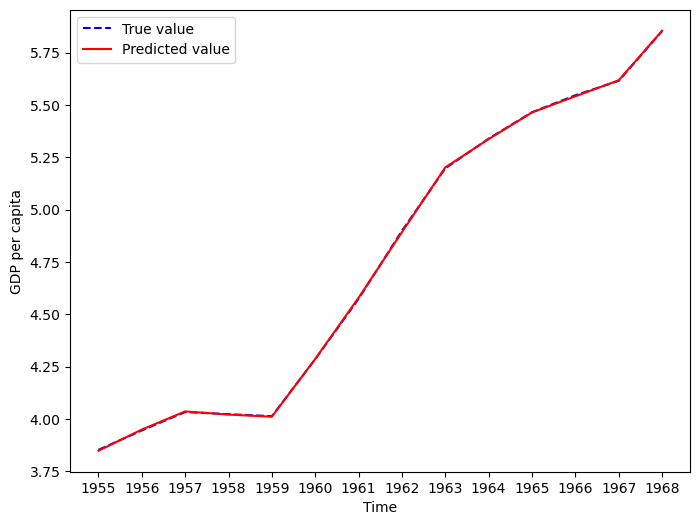

In [ ]:
x = y0t.index
y1 = y0t_y
y2 = y0t_pred
plt.figure(figsize=(8, 6))  # Optional: specify the figure size
plt.plot(x, y1, label='True value', color='blue', linestyle='--')
plt.plot(x, y2, label='Predicted value', color='red', linestyle='-')

# Add labels and a legend
plt.xlabel('Time')
plt.ylabel('GDP per capita')
plt.legend()


In [ ]:
y1t_pred = lasso_cv.predict(y1t.iloc[:, 1:])
y1t_y = y1t.iloc[:, 0]

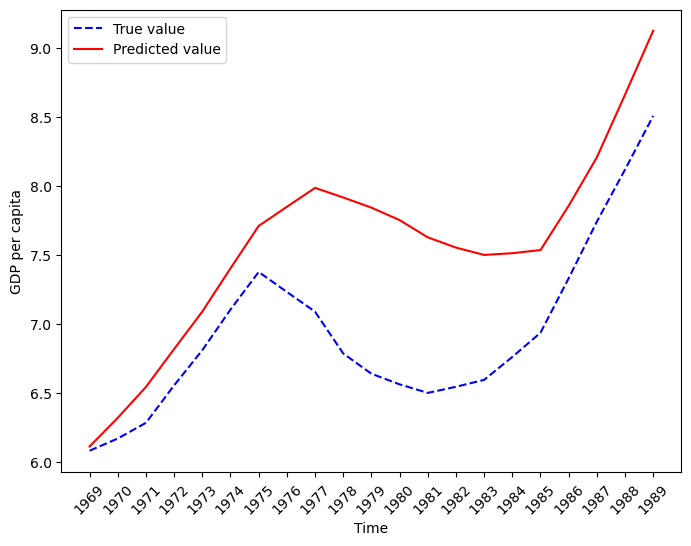

In [ ]:
x = y1t.index
y1 = y1t_y
y2 = y1t_pred
plt.figure(figsize=(8, 6))  # Optional: specify the figure size
plt.plot(x, y1, label='True value', color='blue', linestyle='--')
plt.plot(x, y2, label='Predicted value', color='red', linestyle='-')

# Add labels and a legend
plt.xlabel('Time')
plt.ylabel('GDP per capita')
plt.xticks(rotation=45)
plt.legend()


In [ ]:
# put them together
x = y.T.index
y_true = y.iloc[0,:]
y_pred = np.concatenate((y0t_pred, y1t_pred))

In [ ]:
trace1 = go.Scatter(x=x, y=y_true, mode='lines', name='True value')
trace2 = go.Scatter(x=x, y=y_pred, mode='lines', name='Predicted value')

# Create the layout
layout = go.Layout(
    title='True and Predicted values',
    xaxis=dict(title='time'),
    yaxis=dict(title='GDP per cap')
)

# Create a figure with both traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the interactive plot
fig.show()